<a href="https://colab.research.google.com/github/Salemander466/ML-Uni-assiment-1-Pokemon-/blob/main/Working_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
from PIL import Image
import os
import re

import torch.nn.functional as F
import numpy as np
from torch.nn import AdaptiveAvgPool2d
from skimage.metrics import structural_similarity as ssim
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
from skimage.metrics import structural_similarity as ssim


import os
import re


Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/'
subfolders = ['START', 'MID', 'END']

scm = []


# Create a list of all the image files
image_files = []
for subfolder in subfolders:
    folder_path = os.path.join(data_path, subfolder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            image_files.append(os.path.join(folder_path, filename))

# Sort the image files numerically from lowest to highest
image_files = sorted(image_files, key=lambda x: int(re.findall('\d+', x)[-1]))

print(image_files)


['/content/drive/MyDrive/GAN Data 1 (stickman ) 192/START/image_000.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/MID/image_000.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/END/image_000.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/START/image_001.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/MID/image_001.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/END/image_001.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/START/image_002.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/MID/image_002.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/END/image_002.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/START/image_003.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/MID/image_003.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/END/image_003.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/START/image_004.jpg', '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/MID/image_004.j

In [1]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Define the start encoder layers
        self.start_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, 3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Define the end encoder layers
        self.end_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, 3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
                # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(6144, 2048, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(2048, 1024, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, start_imgs, end_imgs, noise):
        start_features = self.start_encoder(start_imgs)
        end_features = self.end_encoder(end_imgs)

        # Get the dimensions of the start_features tensor
        batch_size, _, h, w = start_features.size()

        # Reshape the noise tensor to match the dimensions of start_features and end_features
        noise = noise.expand(batch_size, -1, h, w)

        # Combine the features from start and end images and the noise
        combined_features = torch.cat((start_features, end_features, noise), 1)

        # Pass the combined features through the decoder
        x = self.decoder(combined_features)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 16, 4, 1, 0, bias=False)
        self.fc1 = nn.Linear(16*9*9, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.conv5(x)
        #print("Shape of x after conv5:", x.shape)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.fc2(x)
        return x



class StickmanDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.subfolders = ['START', 'MID', 'END']
        self.image_files = []
        for subfolder in self.subfolders:
            folder_path = os.path.join(data_path, subfolder)
            for filename in sorted(os.listdir(folder_path)):
                if filename.endswith('.jpg'):
                    self.image_files.append(os.path.join(folder_path, filename))
                    
    def __len__(self):
        return len(self.image_files) - 2
    
    def __getitem__(self, idx):
        start_img_path = self.image_files[idx]
        mid_img_path = self.image_files[idx+1]
        end_img_path = self.image_files[idx+2]
        
        start_img = Image.open(start_img_path).convert('RGB')
        mid_img = Image.open(mid_img_path).convert('RGB')
        end_img = Image.open(end_img_path).convert('RGB')
        
        if self.transform:
            start_img = self.transform(start_img)
            mid_img = self.transform(mid_img)
            end_img = self.transform(end_img)
        
        # Generate noise tensor
        noise = torch.randn_like(start_img)
        
        return start_img, end_img, mid_img, noise


NameError: ignored

In [ ]:
import os

output_dir = '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/generated/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [7]:
# Define the training loop
def train_gan(generator, discriminator, dataloader, num_epochs=10, lr=0.0002, beta1=0.5, beta2=0.999, device=torch.device('cuda')):
    scm = []
    # Define the loss function and optimizers
    criterion = nn.BCEWithLogitsLoss()

    # Define the optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Define the learning rate and the schedule
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer_g, milestones=[40], gamma=0.1)

    # Move the models to the device
    generator.to(device)
    discriminator.to(device)

    # Set the models to train mode
    generator.train()
    discriminator.train()

    # Define the fixed noise for visualization
    fixed_noise = torch.randn(1, 100, 1, 1, device=device)

    # Start the training loop
    for epoch in range(num_epochs):
        for i, (start_imgs, end_imgs, mid_imgs) in enumerate(dataloader):
            batch_size = start_imgs.size(0)

            # Train the discriminator
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train the discriminator on real data
            real_scores = discriminator(mid_imgs.to(device)).view(-1, 1)
            d_loss_real = criterion(real_scores, torch.ones(batch_size, 1, device=device))

            # Train the discriminator on fake data
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_imgs = generator(start_imgs.to(device), end_imgs.to(device), noise)
            fake_scores = discriminator(fake_imgs.detach()).view(-1, 1)
            d_loss_fake = criterion(fake_scores, torch.zeros(batch_size, 1, device=device))

            # Compute the total discriminator loss and update the discriminator
            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            # Train the generator
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_imgs = generator(start_imgs.to(device), end_imgs.to(device), noise)
            fake_scores = discriminator(fake_imgs).view(-1, 1)
            g_loss = criterion(fake_scores, real_labels)

            # Update the generator
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

        # Compute the SSIM score between the generated image and the ground truth image
        fake_img = generator(start_imgs[:1].to(device), end_imgs[:1].to(device), fixed_noise)
        fake_img = utils.make_grid(fake_img.detach().cpu(), normalize=True)
        real_img = utils.make_grid(mid_imgs[:1].cpu(), normalize=True)
        ssim_score = ssim(fake_img.permute(1, 2, 0).numpy(), real_img.permute(1, 2, 0).numpy(), multichannel=True)

        # Save a generated image for visualization
        fake_imgs = generator(start_imgs[:1].to(device), end_imgs[:1].to(device), fixed_noise)
        fake_img = utils.make_grid(fake_imgs.detach().cpu(), normalize=True)
        utils.save_image(fake_img, '/content/drive/MyDrive/GAN Data 1 (stickman ) 192/generated/fake_epoch%d.png' % (epoch+1))



        # Print the SSIM score
        print('[Epoch %d/%d]\tSSIM score: %.4f' % (epoch+1, num_epochs, ssim_score))
        scm.append(ssim_score)
    #scm.append("xx")
    print(scm)
    return scm


In [ ]:
print(scm)

[0.16824186, 0.5268975, 0.31856617, 0.47185984, 0.49891558, 0.5278409, 0.4049144, 0.55103225, 0.6904609, 0.66577613, 0.10174275, 0.0951015, 0.10963523]


In [10]:

# Define the dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
stickman_dataset = StickmanDataset('/content/drive/MyDrive/GAN Data 1 (stickman ) 192/', transform=transform)
dataloader = DataLoader(stickman_dataset, batch_size=16, shuffle=True, num_workers=2)

# Define the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Train the GAN
train_gan(generator, discriminator, dataloader, num_epochs=300, lr=0.0002, beta1=0.5, beta2=0.999, device=torch.device('cuda'))



RuntimeError: ignored

In [ ]:
#testing hyper paramaters
#print(train_gan(generator, discriminator, dataloader, num_epochs=3, lr=0.0002, beta1=0.5, beta2=0.999, device=torch.device('cuda')))
x = [0.0002,0.000175,0.00015,0.000125,0.0001]
tsc = []

for hyp in x: 
  print(hyp)
  tsc.append(train_gan(generator, discriminator, dataloader, num_epochs=45, lr=hyp, beta1=0.55, beta2=0.999, device=torch.device('cuda')))
print(tsc)

0.0002
[Epoch 1/45]	SSIM score: 0.7284


<ipython-input-30-717cedb490b3>:65: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(fake_img.permute(1, 2, 0).numpy(), real_img.permute(1, 2, 0).numpy(), multichannel=True)


[Epoch 2/45]	SSIM score: 0.7373
[Epoch 3/45]	SSIM score: 0.7785
[Epoch 4/45]	SSIM score: 0.7309
[Epoch 5/45]	SSIM score: 0.6133
[Epoch 6/45]	SSIM score: 0.7184
[Epoch 7/45]	SSIM score: 0.7152
[Epoch 8/45]	SSIM score: 0.6552
[Epoch 9/45]	SSIM score: 0.6188
[Epoch 10/45]	SSIM score: 0.6933
[Epoch 11/45]	SSIM score: 0.7274
[Epoch 12/45]	SSIM score: 0.6468
[Epoch 13/45]	SSIM score: 0.6802
[Epoch 14/45]	SSIM score: 0.6690
[Epoch 15/45]	SSIM score: 0.6854
[Epoch 16/45]	SSIM score: 0.7598
[Epoch 17/45]	SSIM score: 0.8184
[Epoch 18/45]	SSIM score: 0.7825
[Epoch 19/45]	SSIM score: 0.5871
[Epoch 20/45]	SSIM score: 0.6730
[Epoch 21/45]	SSIM score: 0.7851
[Epoch 22/45]	SSIM score: 0.7346
[Epoch 23/45]	SSIM score: 0.5444
[Epoch 24/45]	SSIM score: 0.8090
[Epoch 25/45]	SSIM score: 0.7363
[Epoch 26/45]	SSIM score: 0.7583
[Epoch 27/45]	SSIM score: 0.7304
[Epoch 28/45]	SSIM score: 0.7875
[Epoch 29/45]	SSIM score: 0.7797
[Epoch 30/45]	SSIM score: 0.7105
[Epoch 31/45]	SSIM score: 0.7228
[Epoch 32/45]	SSIM

Slope of the line: 0.00010983150781222082
0.7098776419957479


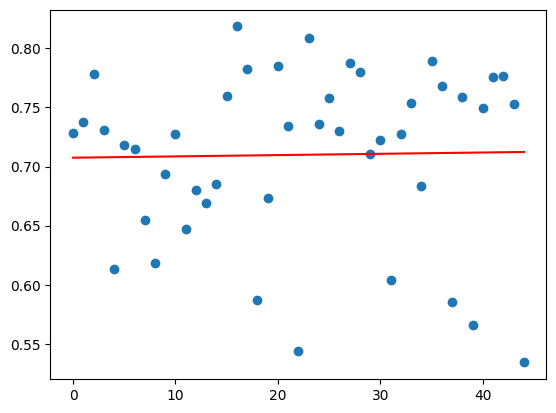

Slope of the line: -0.0024820372953088155
0.6377448459466298


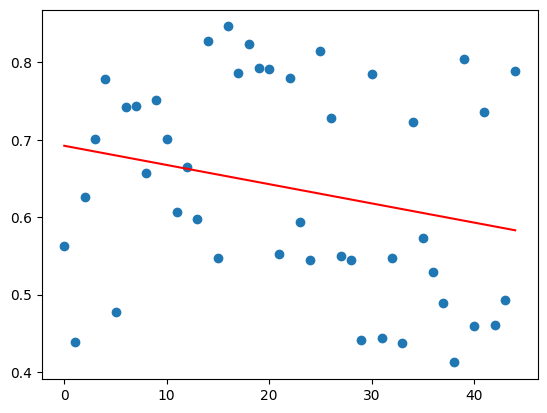

Slope of the line: -0.0026122126654673874
0.5535874863465627


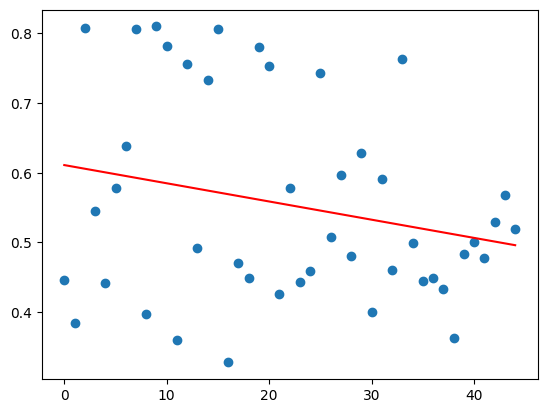

Slope of the line: -0.0007528922774574971
0.5572856267293295


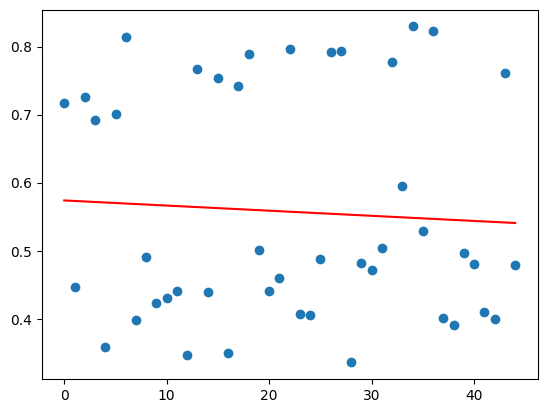

Slope of the line: 0.0021674452091865375
0.5481988830698861


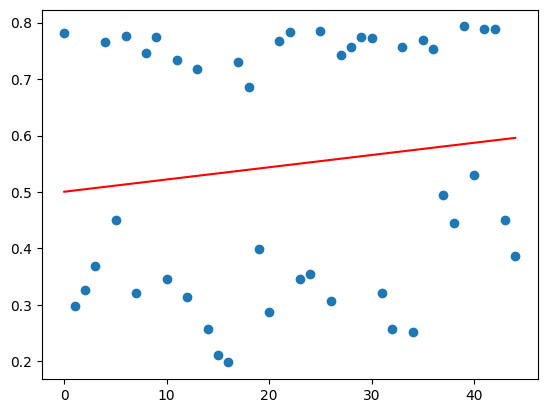

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the nested lists
nested_lists = tsc

# Loop through each nested list
for lst in nested_lists:
    # Convert the list to a numpy array
    data = np.array(lst)
    
    # Create an x-axis array from 0 to the length of the list
    x = np.arange(len(data))
    
    # Fit a straight line to the data using numpy's polyfit function
    slope, intercept = np.polyfit(x, data, 1)
    
    # Plot the data and the line
    plt.scatter(x, data)
    plt.plot(x, slope*x + intercept, 'r')
    
    # Print the slope of the line
    print("Slope of the line:", slope)
    print(sum(lst)/len(lst))
    # Show the plot
    plt.show()


Slope of line for nested list: 0.00010983150781222082
Variance within nested list: 0.005197329
0.7098776419957479
Slope of line for nested list: -0.0024820372953088155
Variance within nested list: 0.018006057
0.6377448459466298
Slope of line for nested list: -0.0026122126654673874
Variance within nested list: 0.020601435
0.5535874863465627
Slope of line for nested list: -0.0007528922774574971
Variance within nested list: 0.027142253
0.5572856267293295
Slope of line for nested list: 0.0021674452091865375
Variance within nested list: 0.04740986
0.5481988830698861


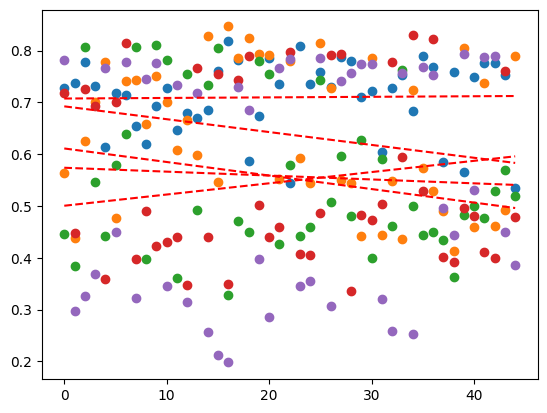

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create the nested list of data
data = tsc

# Plot the data and fit a straight line through each nested list
for nested_list in data:
    x = range(len(nested_list))
    y = nested_list
    plt.scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    print("Slope of line for nested list:", z[0])
    
    # Calculate variance within the nested list
    variance = np.var(nested_list)
    print("Variance within nested list:", variance)
    print(sum(nested_list)/len(nested_list))
# Show the plot
plt.show()
